# Coverage of social infrastructure

**Objetive:** <br>
The following notebook shows the step-by-step to calculate the population covered by social infrastructure in LAC (banks, ATMs, hospitals, etc.). <br>
_For H3 calculations we followed Ravihara (2021) [article](https://medium.com/analytics-vidhya/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-458f51593548) in Medium._ <br><br>

Author: Laura Goyeneche, Consultant SPH, lauragoy@iadb.org <br>
Created: March 20, 2023

## 1. Basics

In [1]:
%%capture
# Libraries
import os 
import re
import time
import dotenv
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas.tools import sjoin
from shapely.geometry import Polygon
from h3 import geo_to_h3, h3_to_geo_boundary

# Modules
from utils import get_iadb, get_country_shp

In [2]:
# Working environments
dotenv.load_dotenv()
sclbucket   = os.environ.get("sclbucket")
scldatalake = os.environ.get("scldatalake")

## 2. Inputs

In [3]:
# Country names 
data = get_iadb()

### 2.1. Isochrones

In [5]:
code      = "COL"
amenity   = "healthcare"
profile   = "driving"
minute    = 30
isochrone = gpd.read_file(f"../data/1-isochrones/{amenity}/{code}-{profile}-{minute}.geojson")

### 2.2. Population

In [6]:
group      = "total_population"
population = pd.read_csv(f"../data/0-raw/population/{group}/{code}_{group}.csv.gz")

In [7]:
geometry   = gpd.points_from_xy(population['longitude'], population['latitude'])
population = gpd.GeoDataFrame(population.copy(), geometry = geometry, crs = 4326)

### 2.3. admin-2 shp

In [8]:
adm2_shp = get_country_shp(code, level = 2)

## 3. Calculate coverage

### 3.1. Coverage at admin-2 level

In [9]:
# Population in isochrone 
pop_iso = gpd.clip(population, isochrone)

In [10]:
# Population in admin-2 level 
pop_adm2 = gpd.sjoin(population, adm2_shp)
pop_adm2 = pop_adm2[["ADM2_PCODE","population"]].groupby("ADM2_PCODE").sum().reset_index()
pop_adm2 = pop_adm2.rename(columns = {"population":"pop_tot"})

In [11]:
# Covered population in admin-2 level
pop_adm2_cov = gpd.sjoin(pop_iso, adm2_shp)
pop_adm2_cov = pop_adm2_cov[["ADM2_PCODE","population"]].groupby("ADM2_PCODE").sum().reset_index()
pop_adm2_cov = pop_adm2_cov.rename(columns = {"population":"pop_cov"})

In [12]:
# Coverage map 
coverage = adm2_shp.copy()
coverage = coverage.merge(pop_adm2    , on = "ADM2_PCODE", how = "left")
coverage = coverage.merge(pop_adm2_cov, on = "ADM2_PCODE", how = "left")
coverage["pop_cov"]   = coverage.pop_cov.fillna(0)
coverage["pop_uncov"] = coverage.pop_tot   - coverage.pop_cov
coverage["per_cov"]   = coverage.pop_cov   * 100 / coverage.pop_tot
coverage["per_uncov"] = coverage.pop_uncov * 100 / coverage.pop_tot

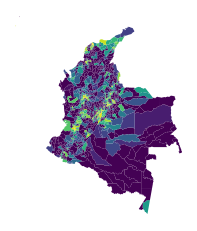

In [16]:
fig, ax = plt.subplots(1)
coverage.plot(column = "per_cov", ax = ax)
plt.axis("off")
fig.show()

### 3.2. Coverage at H3 level

In [18]:
# Calculate H3 cells per population points
resolution            = 6
population_           = population.copy()
population_["hex_id"] = population_.apply(lambda x: geo_to_h3(x["latitude"], x["longitude"], resolution), axis = 1)

In [19]:
# Collapse by H3
h3_population             = population_.groupby("hex_id").population.agg(sum).reset_index()
h3_population["geometry"] = h3_population['hex_id'].apply(lambda x: h3_to_geo_boundary(x, geo_json = True))
h3_population['hex_poly'] = h3_population['geometry'].apply(lambda x: Polygon(x))
h3_population             = gpd.GeoDataFrame(h3_population, geometry = h3_population.hex_poly, crs = "EPSG:4326")

In [20]:
# Covered population in H3 cells
h3_pop_cov = gpd.sjoin(pop_iso, h3_population.drop(columns = "population"))
h3_pop_cov = h3_pop_cov[["hex_id","population"]]
h3_pop_cov = h3_pop_cov.rename(columns = {"population":"pop_cov"})
h3_pop_cov = h3_pop_cov.groupby("hex_id").sum().reset_index()

In [49]:
# H3 coverage map 
h3_coverage = h3_population.merge(h3_pop_cov, on = "hex_id", how = "left")
h3_coverage = h3_coverage.rename(columns = {"population":"pop_tot"})
h3_coverage = h3_coverage.drop(columns = "geometry")
h3_coverage = h3_coverage.rename(columns = {"hex_poly":"geometry"})

In [50]:
# Rename variables 
h3_coverage["pop_cov"]   = h3_coverage.pop_cov.fillna(0)
h3_coverage["pop_uncov"] = h3_coverage.pop_tot   - h3_coverage.pop_cov
h3_coverage["per_cov"]   = h3_coverage.pop_cov   * 100 / h3_coverage.pop_tot
h3_coverage["per_uncov"] = h3_coverage.pop_uncov * 100 / h3_coverage.pop_tot

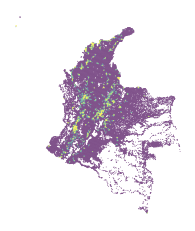

In [58]:
fig, ax = plt.subplots(1)
h3_coverage.plot(column = "per_cov", ax = ax)
plt.axis("off")
fig.show()